In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [3]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, title):
    width = 10
    height=6
    plt.figure(figsize=(width, height))
    
    ax1=sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2=sns.distplot(BlueFunction, hist=False, color="b", label=BlueName)
    
    plt.title(title)
    plt.xlabel("Proportion of Jobs")
    plt.ylabel("Salary (in thousand dollars)")
    plt.show()
    plt.close()

In [4]:
def PollyPlot(X_train, X_test, y_train, y_test, lr, poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    xmax = max([X_train.values.max(), X_test.values.max()])
    xmin = min([X_train.values.min(), X_test.values.min()])
    x = np.arange(xmin, xmax, 0.1)
    
    plt.plot(X_train, y_train, 'ro', label='Training Data')
    plt.plot(X_test, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predict Function')
    plt.ylim(-100, 5000)
    plt.ylabel('Salary')
    plt.legend

In [5]:
def ViolinPlot(data, var):
    data = pd.concat([train_data['salary'], train_data[var]], axis=1)
    f, ax = plt.subplots(figsize=(12, 8))
    fig = sns.violinplot(x=var, y='salary', data=data, scale='count', inner='quartile')
    plt.xticks(rotation=75)

In [6]:
# Load raw data
train_feat = pd.read_csv('/Users/LongHD/Desktop/Salary-Prediction/train_features.csv')
train_sal = pd.read_csv('train_salaries.csv')
test_feat = pd.read_csv('test_features.csv')

# Verify data is loaded
train_feat.head()

,JobID,TenCongTy,ChucVu,TrinhDoHocVan,ChuyenMon,ChuyenNganh,NamKinhNghiem,milesFromMetropolis
0,JobID1,FPT,CEO,MASTERS,JAVA,mobile,10,83
1,JobID2,FSI,CFO,HIGH_SCHOOL,PHP,web,3,73
2,JobID3,EPU,MANAGER,MASTERS,PYTHON,R&D,19,38
3,JobID4,VIETTEL,LEAD,DOCTORAL,PTS,design,8,10
4,JobID5,ABC,LEAD,DOCTORAL,SQL,B.A,8,17


In [7]:
train_sal.head()


,JobID,Luong
0,JobID1,500000
1,JobID2,200000
2,JobID3,300000
3,JobID4,400000
4,JobID5,250000


In [8]:
test_feat.head()

,JobID,TenCongTy,ChucVu,TrinhDoHocVan,ChuyenMon,ChuyenNganh,NamKinhNghiem,milesFromMetropolis
0,JobID1,FPT,CEO,MASTERS,JAVA,mobile,7,83
1,JobID2,FSI,MANAGER,HIGH_SCHOOL,PHP,web,6,73
2,JobID3,EPU,LEAD,MASTERS,PYTHON,R&D,5,38
3,JobID4,VIETTEL,VICE PRESIDENT,DOCTORAL,PTS,design,6,10
4,JobID5,ABC,LEAD,DOCTORAL,SQL,B.A,8,17


In [9]:
print(train_feat.shape)
print(train_sal.shape)
print(test_feat.shape)

(6, 8)
(6, 2)
(6, 8)


In [10]:
train_data = pd.merge(train_feat, train_sal, on ='JobID')

# Check features of merged data
train_data.head()

,JobID,TenCongTy,ChucVu,TrinhDoHocVan,ChuyenMon,ChuyenNganh,NamKinhNghiem,milesFromMetropolis,Luong
0,JobID1,FPT,CEO,MASTERS,JAVA,mobile,10,83,500000
1,JobID2,FSI,CFO,HIGH_SCHOOL,PHP,web,3,73,200000
2,JobID3,EPU,MANAGER,MASTERS,PYTHON,R&D,19,38,300000
3,JobID4,VIETTEL,LEAD,DOCTORAL,PTS,design,8,10,400000
4,JobID5,ABC,LEAD,DOCTORAL,SQL,B.A,8,17,250000


In [11]:
train_data.shape

(6, 9)

In [12]:
# Check for missing data
missing_data = train_data.isnull().sum()
missing_data

JobID                  0
TenCongTy              0
ChucVu                 0
TrinhDoHocVan          0
ChuyenMon              0
ChuyenNganh            0
NamKinhNghiem          0
milesFromMetropolis    0
Luong                  0
dtype: int64

In [15]:
# Check for invalid salaries
zero_salary = train_data['Luong']<=0
invalid_salary = train_data[zero_salary]

invalid_salary

,JobID,TenCongTy,ChucVu,TrinhDoHocVan,ChuyenMon,ChuyenNganh,NamKinhNghiem,milesFromMetropolis,Luong


In [17]:
# Define categorical variables
train_data['JobID']=pd.Categorical(train_data['JobID'])
train_data['TenCongTy']=pd.Categorical(train_data['TenCongTy'])
train_data['ChucVu']=pd.Categorical(train_data['ChucVu'])
train_data['TrinhDoHocVan']=pd.Categorical(train_data['TrinhDoHocVan'])
train_data['ChuyenMon']=pd.Categorical(train_data['ChuyenMon'])
train_data['ChuyenNganh']=pd.Categorical(train_data['ChuyenNganh'])
train_data.dtypes

JobID                  category
TenCongTy              category
ChucVu                 category
TrinhDoHocVan          category
ChuyenMon              category
ChuyenNganh            category
NamKinhNghiem             int64
milesFromMetropolis       int64
Luong                     int64
dtype: object

In [18]:
train_data.describe()

,NamKinhNghiem,milesFromMetropolis,Luong
count,6.000000,6.00000,6.000000
mean,9.166667,39.50000,276666.666667
std,5.344779,31.44996,169312.334656
min,3.000000,10.00000,10000.000000
25%,7.250000,16.25000,212500.000000
50%,8.000000,27.50000,275000.000000
75%,9.500000,64.25000,375000.000000
max,19.000000,83.00000,500000.000000


In [19]:
# Unique values in train_data
train_data.nunique()

JobID                  6
TenCongTy              6
ChucVu                 5
TrinhDoHocVan          3
ChuyenMon              5
ChuyenNganh            6
NamKinhNghiem          5
milesFromMetropolis    6
Luong                  6
dtype: int64

In [20]:
train_data.corr()

,NamKinhNghiem,milesFromMetropolis,Luong
NamKinhNghiem,1.000000,-0.087452,0.299100
milesFromMetropolis,-0.087452,1.000000,0.388367
Luong,0.299100,0.388367,1.000000


Salary Skewness: -0.39585571807350234
Salary Kurtosis: 0.4037669010275833

Salary distribution is approximately symmetric


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


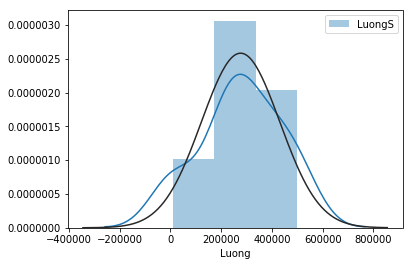

In [23]:
# Find amount of skewness and kurtosis. Plot distribution curve (blue) next to normal distribution (black).
print('Salary Skewness:', train_data['Luong'].skew())
print('Salary Kurtosis:', train_data['Luong'].kurt())
print()
if -0.5 <= train_data['Luong'].skew() <= 0.5:
    print('Salary distribution is approximately symmetric')
elif -0.5 >  train_data['salary'] > 0.5:
    print('Salary distribution is skewed')

sns.distplot(train_data['Luong'], fit=norm, label='LuongS')
plt.legend()

(0, 2319167.3251800314)

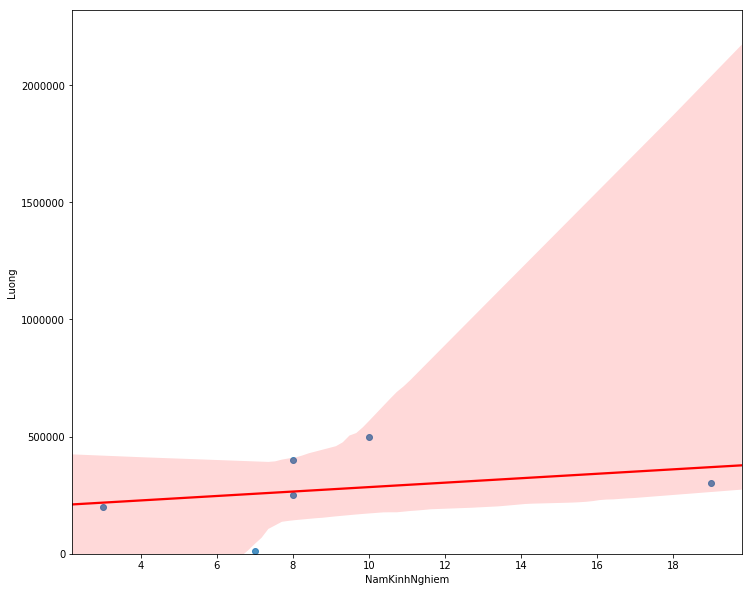

In [27]:
# Plot regression line on years of experience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x='NamKinhNghiem', y='Luong', data=train_data, line_kws={'color':'red'})
plt.ylim(0,)

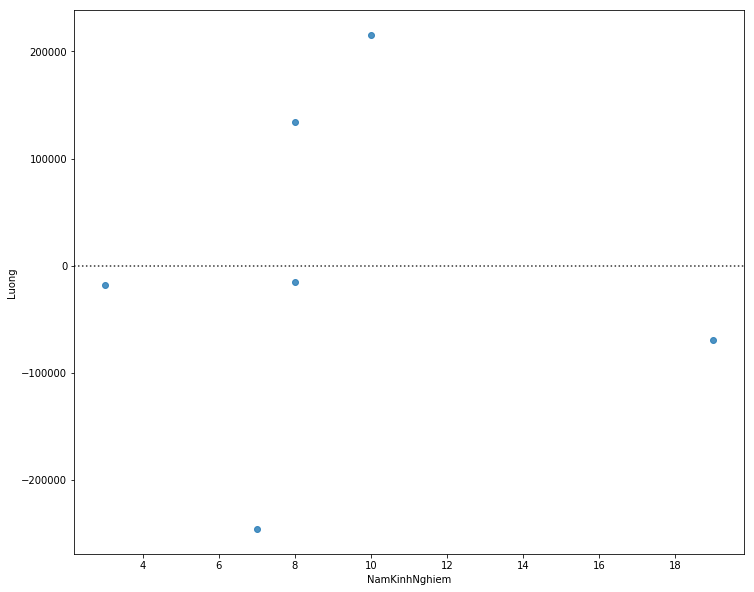

In [29]:
# Plot variance of years of experience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.residplot(train_data['NamKinhNghiem'], train_data['Luong'])
plt.show()

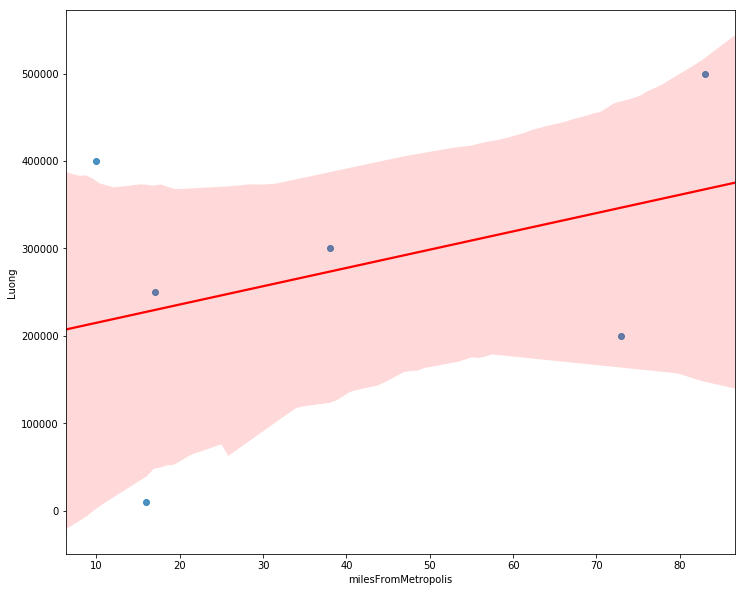

In [31]:
# Plot regression line on years of experience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x='milesFromMetropolis', y='Luong', data=train_data, line_kws={'color':'red'})

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

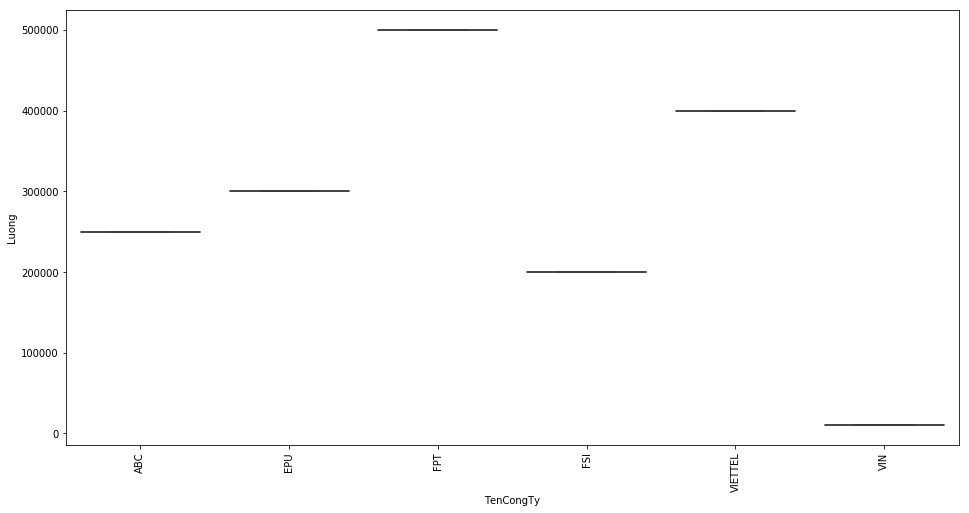

In [32]:
# Plot boxplots for companyId
width = 16
height = 8
var = 'TenCongTy'
data = pd.concat([train_data['Luong'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.boxplot(x=var, y='Luong', data=data)
plt.xticks(rotation=90)